## **Step 1 : importing Essential Libraries**



In [1]:

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(11) 
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.wrappers.scikit_learn import KerasClassifier
from keras.applications.resnet50 import ResNet50
from keras import backend as K 

# **Step 2 : Loading pictures and making Dictionary of images and labels**

In [2]:
'''folder_benign_train = '/content/drive/My Drive/Melanoma_project/train/benign'
folder_malignant_train = '/content/drive/My Drive/Melanoma_project/train/malignant'

folder_benign_test = '/content/drive/My Drive/Melanoma_project/test/benign'
folder_malignant_test = '/content/drive/My Drive/Melanoma_project/test/malignant'
'''

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

In [4]:
from google.colab import drive
from pathlib import Path

# refer : https://medium.com/datadriveninvestor/speed-up-your-image-training-on-google-colab-dc95ea1491cf

zip_path = '/content/drive/My Drive/Melanoma_project/image_folder.zip'
!cp "{zip_path}" .
!unzip -q image_folder.zip
!rm image_folder.zip  # to copy the zip from drive to colab and then get the data - makes the loading process much faster

In [5]:
# Load in training pictures 
import os
ims_benign = [read(os.path.join('/content/train/benign', filename)) for filename in os.listdir('/content/train/benign')]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join('/content/train/malignant', filename)) for filename in os.listdir('/content/train/malignant')]
X_malignant = np.array(ims_malignant, dtype='uint8')


In [6]:
# Load in testing pictures

ims_benign = [read(os.path.join('/content/test/benign', filename)) for filename in os.listdir('/content/test/benign')]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join('/content/test/malignant', filename)) for filename in os.listdir('/content/test/malignant')]
X_malignant_test = np.array(ims_malignant, dtype='uint8')


In [7]:
# Create labels

y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


In [8]:
# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

In [9]:
# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]

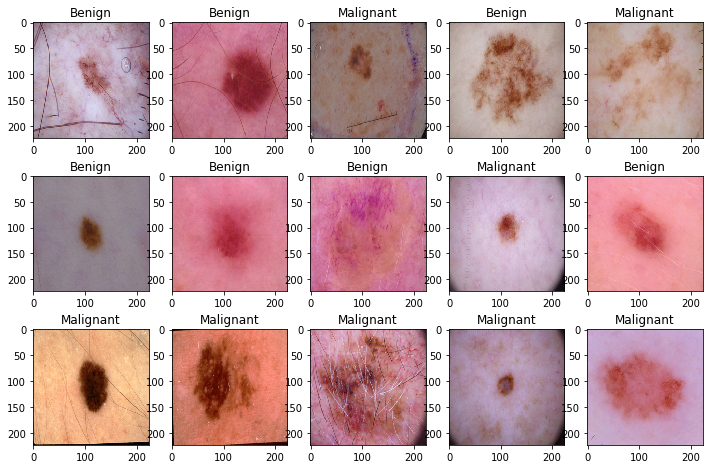

In [10]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

## **Step 3: Categorical Labels**

In [11]:
y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

## **Step 4 : Normalization**

In [12]:
# With data augmentation to prevent overfitting 
X_train = X_train/255.
X_test = X_test/255.

# **Step 5: Model Building**

**CNN**

I used the Keras Sequential API, where you have just to add one layer at a time, starting from the input.

The first is the convolutional (Conv2D) layer. It is like a set of learnable filters. I choosed to set 64 filters for the two firsts conv2D layers. Each filter transforms a part of the image (defined by the kernel size) using the kernel filter. The kernel filter matrix is applied on the whole image. Filters can be seen as a transformation of the image.

The CNN can isolate features that are useful everywhere from these transformed images (feature maps).

The second important layer in CNN is the pooling (MaxPool2D) layer. This layer simply acts as a downsampling filter. It looks at the 2 neighboring pixels and picks the maximal value. These are used to reduce computational cost, and to some extent also reduce overfitting. We have to choose the pooling size (i.e the area size pooled each time) more the pooling dimension is high, more the downsampling is important.

Combining convolutional and pooling layers, CNN are able to combine local features and learn more global features of the image.

Dropout is a regularization method, where a proportion of nodes in the layer are randomly ignored (setting their wieghts to zero) for each training sample. This drops randomly a propotion of the network and forces the network to learn features in a distributed way. This technique also improves generalization and reduces the overfitting.

'relu' is the rectifier (activation function max(0,x). The rectifier activation function is used to add non linearity to the network.

The Flatten layer is use to convert the final feature maps into a one single 1D vector. This flattening step is needed so that you can make use of fully connected layers after some convolutional/maxpool layers. It combines all the found local features of the previous convolutional layers.

In the end i used the features in one fully-connected (Dense) layer which is just artificial an neural networks (ANN) classifier.

In [14]:
# See learning curve and validation curve

def build(input_shape= (224,224,3), lr = 1e-3, num_classes= 2,
          init= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',    
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)


In [16]:
# defining parameters:
input_shape = (224,224,3)
lr = 1e-5
init = 'normal'
activ = 'relu'
optim = 'adam'
epochs = 50  # originally : 50
batch_size = 64

# Building the model :

model = build(lr=lr, init= init, activ= activ, optim=optim, input_shape= input_shape)

# Getting number of layers in the model and the layers in a list :

print("Number of layers in the CNN : ",len(model.layers))

layer_names = [] 
  
for layer in model.layers: 
  layer_names.append(layer.name) 
print(layer_names)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)           

 Visualizing intermediate activations (Output of each layer)



(1, 224, 224, 3)


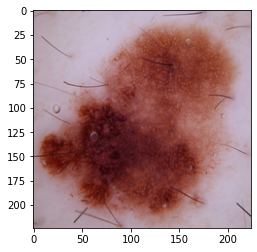

In [17]:
from keras.preprocessing import image 
import numpy as np 

# Pre-processing the image 
img = image.load_img('/content/test/malignant/1007.jpg', target_size = (224,224)) 
img_tensor = image.img_to_array(img) 
img_tensor = np.expand_dims(img_tensor, axis = 0) 
img_tensor = img_tensor / 255.

# Print image tensor shape 
print(img_tensor.shape) 

# Print image 
import matplotlib.pyplot as plt 
plt.imshow(img_tensor[0]) 
plt.show() 

Using Keras Model class to get outputs of each layer

(1, 224, 224, 64)


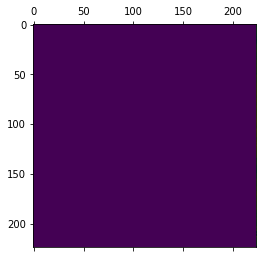

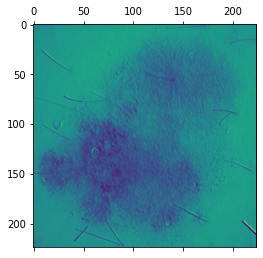

In [19]:
# Outputs of the 8 layers, which include conv2D and max pooling layers 

from keras import models 

layer_outputs = [layer.output for layer in model.layers] 
activation_model = models.Model(inputs = model.input, outputs = layer_outputs) 
activations = activation_model.predict(img_tensor) 

# Getting Activations of first layer 
first_layer_activation = activations[0] 

# shape of first layer activation 
print(first_layer_activation.shape) 

# 6th channel of the image after first layer of convolution is applied 
plt.matshow(first_layer_activation[0, :, :, 6], cmap ='viridis') 

# 15th channel of the image after first layer of convolution is applied 
plt.matshow(first_layer_activation[0, :, :, 15], cmap ='viridis') 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


MemoryError: ignored

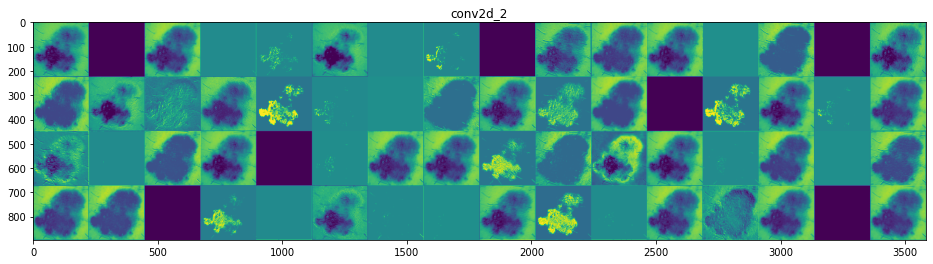

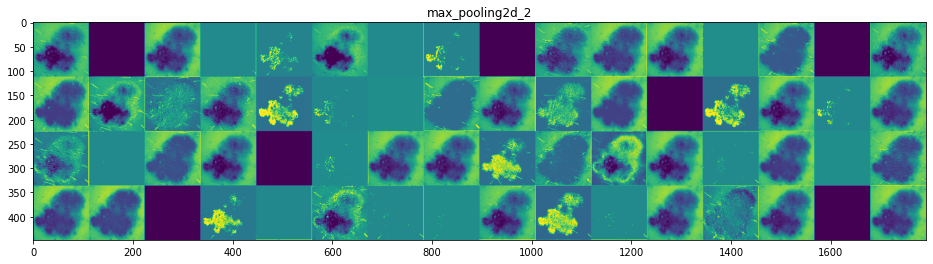

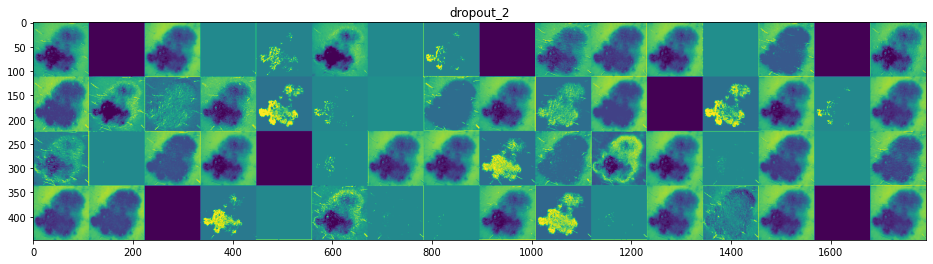

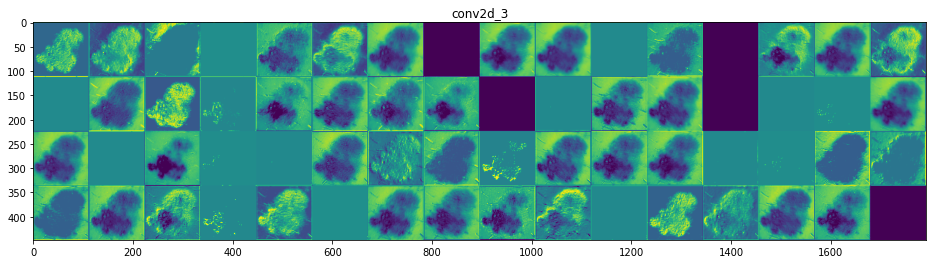

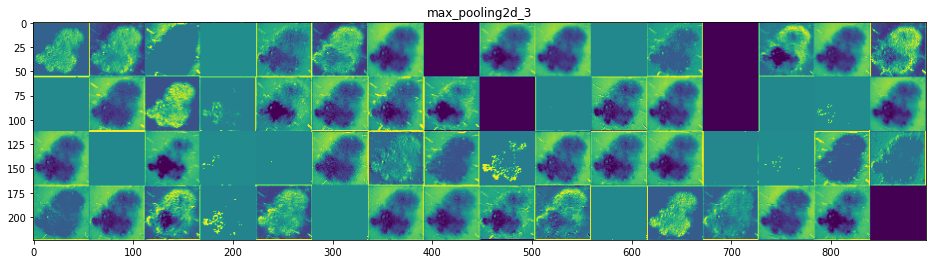

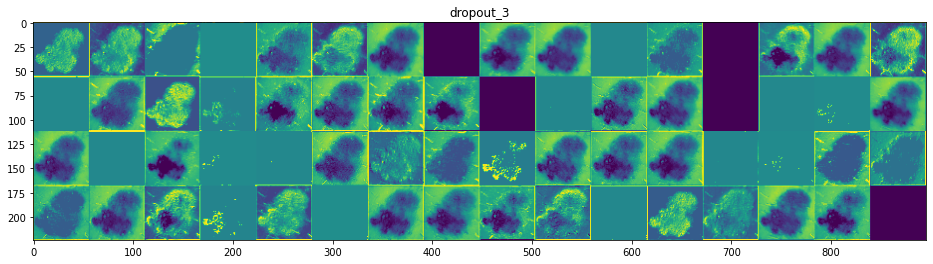

In [22]:
layer_names = []
for layer in model.layers:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )
                   
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [23]:
K.clear_session()
del model
del history

NameError: ignored

# **Step 6: Cross-Validating Model**

In [24]:
# define 3-fold cross validation test harness
kfold = KFold(n_splits=3, shuffle=True, random_state=11)

cvscores = []

for train, test in kfold.split(X_train, y_train):
  # create model
    
    model = build(lr=lr, 
                  init= init, 
                  activ= activ, 
                  optim=optim, 
                  input_shape= input_shape)
    
    # Fit the model
    model.fit(X_train[train], y_train[train], epochs=epochs, batch_size=batch_size, verbose=0)
    # evaluate the model
    scores = model.evaluate(X_train[test], y_train[test], verbose=0)
    print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
    cvscores.append(scores[1] * 100)
    K.clear_session()
    del model
    break
    
print("%.2f%% (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

# **Step 7: Testing the model**

In [25]:
# Fitting model to all data
model = build(lr=lr, 
              init= init, 
              activ= activ, 
              optim=optim, 
              input_shape= input_shape)

model.fit(X_train, y_train,
          epochs=epochs, batch_size= batch_size, verbose=0,
          callbacks=[learning_rate_reduction]
         )



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

In [32]:
# Testing model on test data to evaluate
y_pred = model.predict_classes(X_test)

print(accuracy_score(np.argmax(y_test, axis=1),y_pred))

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report

# Accuracy
print("accuracy score : ",accuracy_score(np.argmax(y_test, axis=1),y_pred))
# Precision
print("precision score : ",precision_score(np.argmax(y_test, axis=1),y_pred))
# Recall
print("recall score : ",recall_score(np.argmax(y_test, axis=1),y_pred))
# F1-score
print("f1 score : ",f1_score(np.argmax(y_test, axis=1),y_pred))
# F-beta-score
print("f beta score : ",fbeta_score(np.argmax(y_test, axis=1),y_pred,beta=10))
# confusion matrix:
print("confusion matrix : ",confusion_matrix(np.argmax(y_test, axis=1),y_pred))

0.6393939393939394
accuracy score :  0.6393939393939394
precision score :  0.9428571428571428
recall score :  0.22
f1 score :  0.3567567567567568
f beta score :  0.22168274027269708
confusion matrix :  [[356   4]
 [234  66]]


In [33]:
# save model
model.save('/content/drive/My Drive/Melanoma_project/cnn_saved_model.h5')
# serialize model to JSON
'''
model_json = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# Clear memory, because of memory overload
del model
K.clear_session()
'''

'\nmodel_json = model.to_json()\n\nwith open("model.json", "w") as json_file:\n    json_file.write(model_json)\n    \n# serialize weights to HDF5\nmodel.save_weights("model.h5")\nprint("Saved model to disk")\n\n# Clear memory, because of memory overload\ndel model\nK.clear_session()\n'

# **Step 8: ResNet50**

The CNN above is not a very sophisticated model, thus the resnet50, is also tried

In [34]:
input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])
'''
history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
'''

"\nhistory = model.fit(X_train, y_train, validation_split=0.2,\n                    epochs= epochs, batch_size= batch_size, verbose=2, \n                    callbacks=[learning_rate_reduction]\n                   )\n\n# list all data in history\nprint(history.history.keys())\n# summarize history for accuracy\nplt.plot(history.history['accuracy'])\nplt.plot(history.history['val_accuracy'])\nplt.title('model accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()\n# summarize history for loss\nplt.plot(history.history['loss'])\nplt.plot(history.history['val_loss'])\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\nplt.legend(['train', 'test'], loc='upper left')\nplt.show()\n"

In [ ]:
# Train ResNet50 on all the data
model.fit(X_train, y_train,
          epochs=epochs, batch_size= epochs, verbose=2,
          callbacks=[learning_rate_reduction]
         )

Epoch 1/50
53/53 - 34s - loss: 0.5906 - accuracy: 0.6947
Epoch 2/50
53/53 - 32s - loss: 0.4386 - accuracy: 0.7854
Epoch 3/50
53/53 - 33s - loss: 0.4232 - accuracy: 0.7956
Epoch 4/50
53/53 - 33s - loss: 0.3969 - accuracy: 0.8062
Epoch 5/50
53/53 - 33s - loss: 0.3927 - accuracy: 0.8153
Epoch 6/50
53/53 - 33s - loss: 0.3758 - accuracy: 0.8149
Epoch 7/50
53/53 - 33s - loss: 0.3689 - accuracy: 0.8191
Epoch 8/50
53/53 - 33s - loss: 0.3488 - accuracy: 0.8396
Epoch 9/50


In [ ]:
# Testing model on test data to evaluate
y_pred = model.predict(X_test)
print(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report

# Accuracy
print("accuracy score : ",accuracy_score(np.argmax(y_test, axis=1),y_pred))
# Precision
print("precision score : ",precision_score(np.argmax(y_test, axis=1),y_pred))
# Recall
print("recall score : ",recall_score(np.argmax(y_test, axis=1),y_pred))
# F1-score
print("f1 score : ",f1_score(np.argmax(y_test, axis=1),y_pred))
# F-beta-score
print("f beta score : ",fbeta_score(np.argmax(y_test, axis=1),y_pred,beta=10))
# confusion matrix:
print("confusion matrix : ",confusion_matrix(np.argmax(y_test, axis=1),y_pred))
# save model
model.save('/content/drive/My Drive/Melanoma_project/resnet50_saved_model.h5')

'''
# serialize model to JSON
resnet50_json = model.to_json()

with open("resnet50.json", "w") as json_file:
    json_file.write(resnet50_json)
    
# serialize weights to HDF5
model.save_weights("resnet50.h5")
print("Saved model to disk")
'''

0.7893939393939394
Saved model to disk


In [ ]:
'''
import json

with open("/var/log/colab-jupyter.log", "r") as fo:
  for line in fo:
    print(json.loads(line)['msg'])
    '''

Config option `delete_to_trash` not recognized by `ColabFileContentsManager`.
Writing notebook server cookie secret to /root/.local/share/jupyter/runtime/notebook_cookie_secret
google.colab serverextension initialized.
Serving notebooks from local directory: /
0 active kernels
The Jupyter Notebook is running at:
http://172.28.0.2:9000/
Use Control-C to stop this server and shut down all kernels (twice to skip confirmation).
Kernel started: 8acfaf2b-c98e-4803-b1ea-7122848ba7f5
Adapting to protocol v5.1 for kernel 8acfaf2b-c98e-4803-b1ea-7122848ba7f5
2020-09-10 14:02:16.737558: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
tcmalloc: large alloc 3175538688 bytes == 0x764e6000 @  0x7f906bd751e7 0x7f906326f5e1 0x7f90632d3c78 0x7f90632d3d93 0x7f9063386fed 0x7f906338794e 0x7f906338a2c8 0x7f90634ca276 0x7f90634cbd44 0x7f90634ce492 0x7f90634cf30e 0x5a4a0c 0x5a50d8 0x7f90633927f7 0x59cb00 0x50ed74 0x507f24 0x5165a5 0x50a47f 